In [61]:
# Standard library imports
import os
import random
import gc
import configparser
import pickle
import copy
import tarfile
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import SwinForImageClassification, AutoImageProcessor, AutoModel, AutoModelForImageClassification
from transformers import AdamW
import torch.nn.functional as F

from torch.optim.lr_scheduler import OneCycleLR

from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter

from torch.cuda.amp import GradScaler, autocast

from tqdm.notebook import tqdm

Environment Check

In [2]:
seed = 42

torch.manual_seed(seed)

np.random.seed(seed)

random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Data Preparation

In [3]:
project_config = configparser.ConfigParser()
project_config.read("nih_config.ini")

DATASET = project_config["dataset"]["extracted_data_path"]
TAR_DATA = project_config["dataset"]["tar_data_path"]

LABELS = project_config["labels"]["label_path"]

In [4]:
DATA_NAMES = ["test", "train", "val"]

In [5]:
TEST_DATASET = os.path.join(DATASET, DATA_NAMES[0])
TRAIN_DATASET = os.path.join(DATASET, DATA_NAMES[1])
VAL_DATASET = os.path.join(DATASET, DATA_NAMES[2])

TEST_LABELS = os.path.join(LABELS, "test_labels.csv")
TRAIN_LABELS = os.path.join(LABELS, "train_labels.csv")
VAL_LABELS = os.path.join(LABELS, "val_labels.csv")

In [ ]:
def extract_tar_data(tar_data: str, keys: List[str] = DATA_NAMES, target_dir: str = DATASET) -> None:
    try:
        if not os.path.isdir(tar_data):
            raise FileNotFoundError(f"Directory not found: {tar_data}")

        for file in os.listdir(tar_data):
            if not file.endswith(".tar"):
                continue

            # Determine data type based on filename
            data_type = None
            for key in keys:
                if key.lower() in file.lower():
                    data_type = key
                    break

            if not data_type:
                print(f"Warning: Could not determine data type for {file}")
                continue

            # Create target directory (if it doesn't exist)
            target_data_dir = os.path.join(target_dir, data_type)
            os.makedirs(target_data_dir, exist_ok=True)

            # Extract tar file to the corresponding directory
            tar_file_path = os.path.join(tar_data, file)
            with tarfile.open(tar_file_path, 'r') as tar_ref:
                tar_ref.extractall(target_data_dir)
                print(f"Successfully extracted {file} to {target_data_dir}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
        

extract_tar_data(TAR_DATA, DATA_NAMES, DATASET)

In [7]:
def clean_data(train_path: str, test_path: str, val_path: str) -> None:
    """
    Deletes all .pyd files within the specified directories.
    """

    for dir_path in [train_path, test_path, val_path]:
        for root, _, files in os.walk(dir_path):
            for file in files:
                if file.endswith(".pyd"):
                    file_path = os.path.join(root, file)
                    try:
                        os.remove(file_path)
                    except OSError as e:
                        print(f"Error deleting {file_path}: {e}")

clean_data(TRAIN_DATASET, TEST_DATASET, VAL_DATASET)

In [6]:
test_labels_raw_df = pd.read_csv(TEST_LABELS)
train_labels_raw_df = pd.read_csv(TRAIN_LABELS)
val_labels_raw_df = pd.read_csv(VAL_LABELS)

In [7]:
train_labels_raw_df.head()

,Image Index,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000004_000.png,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,00000007_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000008_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000008_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000008_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [10]:
len(train_labels_raw_df.columns) - 1

14

In [11]:
len(train_labels_raw_df), len(val_labels_raw_df), len(test_labels_raw_df)

(21172, 2896, 6480)

**Data Leakage**

In [12]:
def check_for_leakage(df1, df2, image_index):
    df1_unique = set(df1[image_index].values)
    df2_unique = set(df2[image_index].values)
    return len(df1_unique.intersection(df2_unique)) > 0

In [13]:
print("leakage between train and valid: {}".format(check_for_leakage(train_labels_raw_df, val_labels_raw_df, 'Image Index')))
print("leakage between train and test: {}".format(check_for_leakage(train_labels_raw_df, test_labels_raw_df, 'Image Index')))
print("leakage between valid and test: {}".format(check_for_leakage(val_labels_raw_df, test_labels_raw_df, 'Image Index')))

leakage between train and valid: False
leakage between train and test: False
leakage between valid and test: False


In [14]:
train_labels_raw_df.iloc[0, 1:].values.astype(float)

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
class MedDataset(Dataset):
    def __init__(self, data_dir, labels_df, image_processor, transforms=None):
        self.data_dir = data_dir
        self.labels_df = labels_df
        self.image_processor = image_processor
        self.transforms = transforms
    
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, index):
        # Get the image name and labels
        image_name = self.labels_df.iloc[index]['Image Index']
        labels = self.labels_df.iloc[index, 1:].values.astype(float)
        
        image_path = os.path.join(self.data_dir, image_name)
        
        image = Image.open(image_path).convert("RGB")
        
        # Apply preprocessing
        processed_image = self.image_processor(image, return_tensors="pt")
        image_tensor = processed_image["pixel_values"].squeeze(0)

        if self.transforms:
            image_tensor = self.transforms(image_tensor)
        
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        return image_tensor, labels_tensor

In [9]:
checkpoint_name = "microsoft/swin-tiny-patch4-window7-224"

In [10]:
swin_image_processor = AutoImageProcessor.from_pretrained(checkpoint_name)
swin_model = AutoModelForImageClassification.from_pretrained(checkpoint_name)

In [11]:
# Initialize datasets
train_dataset = MedDataset(
    data_dir=TRAIN_DATASET,
    labels_df=train_labels_raw_df,
    image_processor=swin_image_processor
)

val_dataset = MedDataset(
    data_dir=VAL_DATASET,
    labels_df=val_labels_raw_df,
    image_processor=swin_image_processor
)

test_dataset = MedDataset(
    data_dir=TEST_DATASET,
    labels_df=test_labels_raw_df,
    image_processor=swin_image_processor
)

In [12]:
batch_size = 8 # do it with 32 ra
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Model

In [20]:
swin_image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [21]:
custom_processor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [22]:
model_config = swin_model.config

In [23]:
model_config.hidden_size

768

In [24]:
model_config.hidden_act

'gelu'

In [25]:
swin_model.classifier

Linear(in_features=768, out_features=1000, bias=True)

In [42]:
swin_model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [48]:
swin_model.swin.encoder.layers

ModuleList(
  (0): SwinStage(
    (blocks): ModuleList(
      (0-1): 2 x SwinLayer(
        (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attention): SwinAttention(
          (self): SwinSelfAttention(
            (query): Linear(in_features=96, out_features=96, bias=True)
            (key): Linear(in_features=96, out_features=96, bias=True)
            (value): Linear(in_features=96, out_features=96, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): SwinSelfOutput(
            (dense): Linear(in_features=96, out_features=96, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (drop_path): SwinDropPath(p=0.1)
        (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (intermediate): SwinIntermediate(
          (dense): Linear(in_features=96, out_features=384, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
      

In [49]:
len(swin_model.swin.encoder.layers)

4

* Stage 0: The first stage has 2 blocks with 96 features. This stage is responsible for processing lower-level information such as edges and textures.
* Stage 1: The second stage has 2 blocks with 192 features. This stage processes more complex features, combining the initial low-level information.
* Stage 2: The third stage has 6 blocks with 384 features. At this point, the model captures more semantic information and high-level patterns.
* Stage 3: The fourth stage has 2 blocks with 768 features. This stage is responsible for the most abstract features and task-specific learning.

In [50]:
class SwinModelWithPEFT(nn.Module):
    def __init__(
        self,
        pretrained_model_name="microsoft/swin-tiny-patch4-window7-224",
        lora_r=8,
        lora_alpha=32,
        lora_dropout=0.1,
        unfreeze_layers=2,
    ):
        super(SwinModelWithPEFT, self).__init__()

        self.backbone = AutoModelForImageClassification.from_pretrained(pretrained_model_name)

        self.backbone.classifier = nn.Identity()

        # I'm getting error in Lora, dueto time constraint, I'm skipping this
        """
        lora_config = LoraConfig(
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=["query", "value"],
            task_type="FEATURE_EXTRACTION"
        )

        
        self.backbone = get_peft_model(self.backbone, lora_config)
        """
        
        self._unfreeze_layers(unfreeze_layers)
        
        # print(self.backbone)
        # print(self.backbone.forward.__doc__)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        # print(outputs)
        return outputs
    
    def _unfreeze_layers(self, num_layers_to_unfreeze):
        stages = self.backbone.swin.encoder.layers
        total_stages = len(stages)
        
        ## Freeze layers below the ones we want to unfreeze
        for i, stage in enumerate(stages):
            if i < total_stages - num_layers_to_unfreeze:
                for param in stage.parameters():
                    param.requires_grad = False
            else:
                for block in stage.blocks:
                    for param in block.parameters():
                        param.requires_grad = True
    
    def freeze_all_layers(self):
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze_all_layers(self):
        for param in self.backbone.parameters():
            param.requires_grad = True


class MultiLabelClassifier(nn.Module):
    def __init__(self, feature_dim, hidden_dim=512, num_classes=14):
        super(MultiLabelClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )

    def forward(self, features):
        logits = self.classifier(features)
        return logits
    
    
class MultiLabelModel(nn.Module):
    def __init__(
        self,
        pretrained_model_name="microsoft/swin-tiny-patch4-window7-224",
        num_classes=14,
        hidden_dim=512,
        lora_r=8,
        lora_alpha=32,
        lora_dropout=0.1,
    ):
        super(MultiLabelModel, self).__init__()

        self.feature_extractor = SwinModelWithPEFT(
            pretrained_model_name=pretrained_model_name,
            lora_r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
        )

        feature_dim = self.feature_extractor.backbone.config.hidden_size
        self.classifier = MultiLabelClassifier(
            feature_dim=feature_dim,
            hidden_dim=hidden_dim,
            num_classes=num_classes,
        )

    def forward(self, pixel_values):
        outputs = self.feature_extractor(pixel_values=pixel_values)
        features = outputs.logits

        logits = self.classifier(features)
        return logits

In [51]:
model = MultiLabelModel()

In [60]:
dir(TaskType)[:10]

['CAUSAL_LM',
 'FEATURE_EXTRACTION',
 'QUESTION_ANS',
 'SEQ_2_SEQ_LM',
 'SEQ_CLS',
 'TOKEN_CLS',
 '__add__',
 '__class__',
 '__contains__',
 '__delattr__']

## Loss calculation

In [128]:
train_labels_raw_df.columns

Index(['Image Index', 'Atelectasis', 'Cardiomegaly', 'Effusion',
       'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
       'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening',
       'Hernia'],
      dtype='object')


Distribution of Atelectasis:
Atelectasis
0    19057
1     2115
Name: count, dtype: int64

Distribution of Cardiomegaly:
Cardiomegaly
0    20617
1      555
Name: count, dtype: int64

Distribution of Effusion:
Effusion
0    18718
1     2454
Name: count, dtype: int64

Distribution of Infiltration:
Infiltration
0    17441
1     3731
Name: count, dtype: int64

Distribution of Mass:
Mass
0    20215
1      957
Name: count, dtype: int64

Distribution of Nodule:
Nodule
0    20009
1     1163
Name: count, dtype: int64

Distribution of Pneumonia:
Pneumonia
0    20878
1      294
Name: count, dtype: int64

Distribution of Pneumothorax:
Pneumothorax
0    20218
1      954
Name: count, dtype: int64

Distribution of Consolidation:
Consolidation
0    20285
1      887
Name: count, dtype: int64

Distribution of Edema:
Edema
0    20708
1      464
Name: count, dtype: int64

Distribution of Emphysema:
Emphysema
0    20623
1      549
Name: count, dtype: int64

Distribution of Fibrosis:
Fibrosis
0    20822
1  

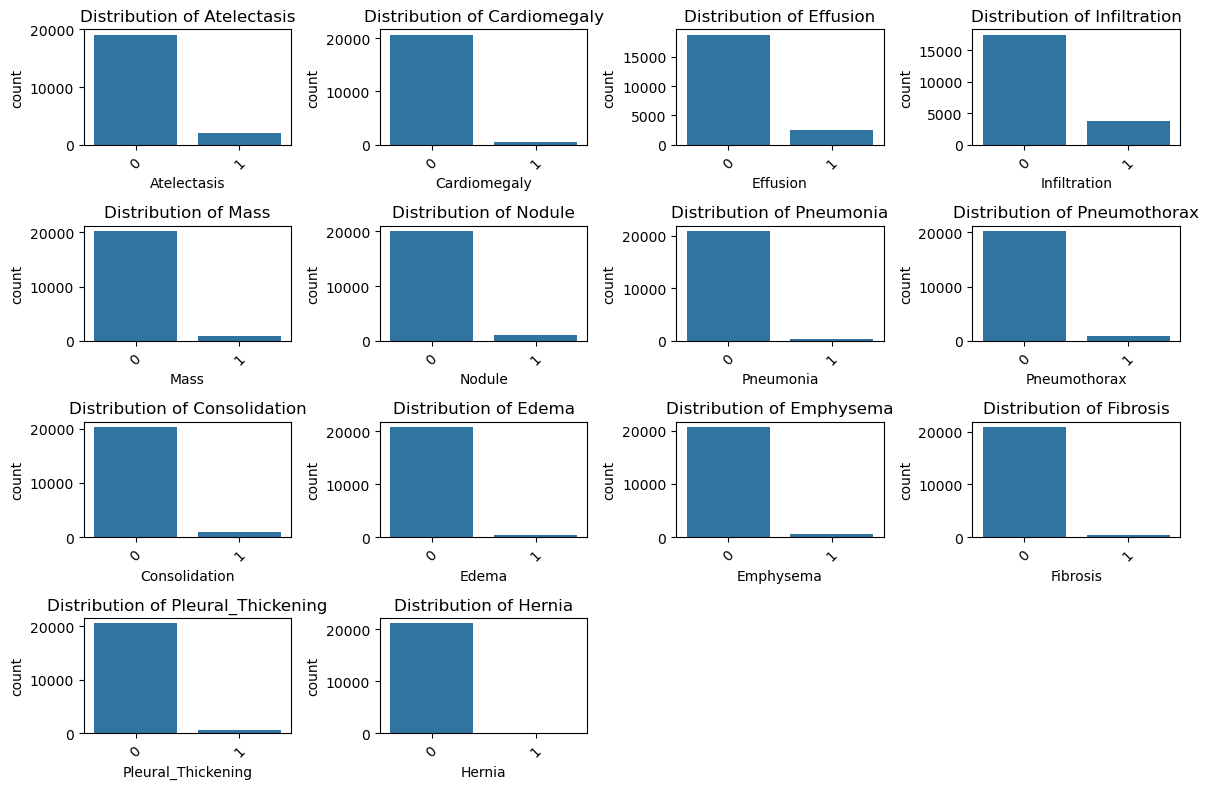

In [129]:
for column in train_labels_raw_df.columns[1:]:
    print(f"\nDistribution of {column}:")
    print(train_labels_raw_df[column].value_counts())

plt.figure(figsize=(12, 8))
for i, column in enumerate(train_labels_raw_df.columns[1:]):
    plt.subplot(4, 4, i+1)
    sns.countplot(x=column, data=train_labels_raw_df)
    plt.title(f"Distribution of {column}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [136]:
train_labels_raw_df.iloc[0, 1:]

Atelectasis           0
Cardiomegaly          0
Effusion              0
Infiltration          0
Mass                  1
Nodule                1
Pneumonia             0
Pneumothorax          0
Consolidation         0
Edema                 0
Emphysema             0
Fibrosis              0
Pleural_Thickening    0
Hernia                0
Name: 0, dtype: object


Overall Sample Distribution:
                 Class  Count
3         Infiltration   3731
2             Effusion   2454
0          Atelectasis   2115
5               Nodule   1163
4                 Mass    957
7         Pneumothorax    954
8        Consolidation    887
12  Pleural_Thickening    633
1         Cardiomegaly    555
10           Emphysema    549
9                Edema    464
11            Fibrosis    350
6            Pneumonia    294
13              Hernia     46


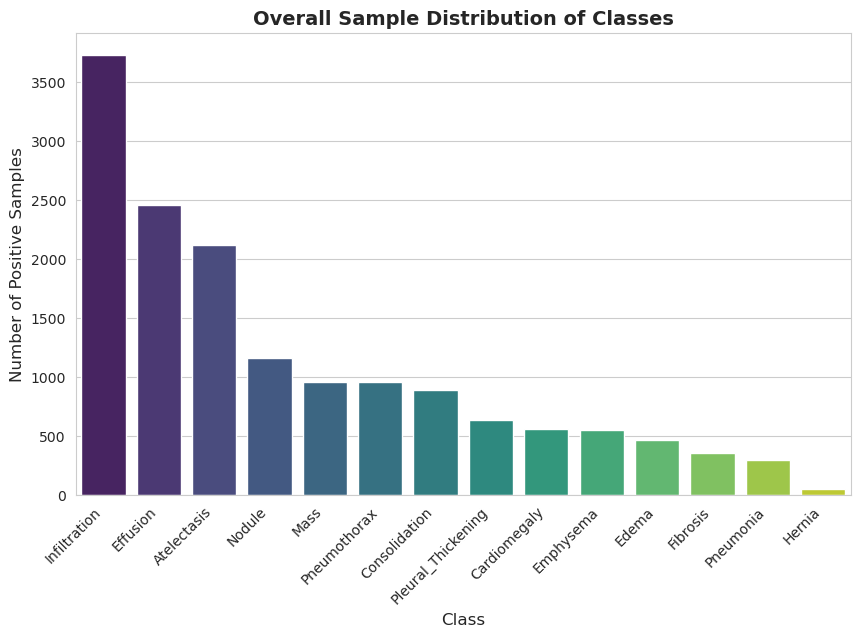

In [146]:
class_counts = train_labels_raw_df.iloc[:, 1:].sum()

class_dist_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})
class_dist_df = class_dist_df.sort_values(by='Count', ascending=False)

print("\nOverall Sample Distribution:")
print(class_dist_df)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(x='Class', y='Count', data=class_dist_df, palette="viridis", hue='Class')
plt.title("Overall Sample Distribution of Classes", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Positive Samples", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


In [15]:
class ModifiedWeightedFocalLoss(nn.Module):
    def __init__(self, class_weights=None, gamma=2.0, alpha=0.25, reduction="mean"):
        super(ModifiedWeightedFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        
        if class_weights is not None:
            self.class_weights = class_weights
        else:
            self.class_weights = torch.ones(14)

    def forward(self, inputs, targets):

        probas = torch.sigmoid(inputs)

        bce_loss = F.binary_cross_entropy(probas, targets, reduction="none")
        
        # modulating factor (1 - p_t) ** gamma
        p_t = probas * targets + (1 - probas) * (1 - targets)
        modulating_factor = (1 - p_t) ** self.gamma
        
        # focal loss term
        focal_loss = self.alpha * modulating_factor * bce_loss

        weighted_loss = focal_loss * self.class_weights

        # final loss
        if self.reduction == "mean":
            return weighted_loss.mean()
        elif self.reduction == "sum":
            return weighted_loss.sum()
        else:
            return weighted_loss


In [170]:
class_counts

Atelectasis           2115
Cardiomegaly           555
Effusion              2454
Infiltration          3731
Mass                   957
Nodule                1163
Pneumonia              294
Pneumothorax           954
Consolidation          887
Edema                  464
Emphysema              549
Fibrosis               350
Pleural_Thickening     633
Hernia                  46
dtype: int64

In [16]:
total_samples = len(train_labels_raw_df)

positive_counts = train_labels_raw_df.iloc[:, 1:].sum(axis=0)

class_weights = total_samples / positive_counts

normalized_class_weights = class_weights / class_weights.max()

In [17]:
normalized_class_weights.values

array([0.02174941, 0.08288288, 0.01874491, 0.01232913, 0.04806688,
       0.03955288, 0.15646259, 0.04821803, 0.0518602 , 0.09913793,
       0.08378871, 0.13142857, 0.07266983, 1.        ])

In [18]:
normalized_class_weights.values.sum()

1.8668919412990093

In [19]:
class_weights.values.sum()

859.2573082865788

In [20]:
type(normalized_class_weights)

pandas.core.series.Series

In [21]:
weights = torch.tensor(normalized_class_weights.values)

In [22]:
weights

tensor([0.0217, 0.0829, 0.0187, 0.0123, 0.0481, 0.0396, 0.1565, 0.0482, 0.0519,
        0.0991, 0.0838, 0.1314, 0.0727, 1.0000], dtype=torch.float64)

## Train

### Param

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_loader), epochs=50)
criterion = ModifiedWeightedFocalLoss(class_weights=weights, gamma=2.0, alpha=0.25, reduction="mean")

/home/jerlshin/anaconda3/envs/gnn/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [199]:
sample_data = train_dataset[0]

In [202]:
type(sample_data)

tuple

In [28]:
image_path = "/home/jerlshin/FieldOfInterest/My_Work/afnan/nih-chest-xray-webdataset-subset-main/Extracted_DATASET/train/00023969_000.png"


In [29]:
image = Image.open(image_path).convert("RGB")
processed_image = swin_image_processor(image, return_tensors="pt")

In [30]:
processed_image.keys()

dict_keys(['pixel_values'])

In [31]:
processed_image["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [32]:
processed_image["pixel_values"].squeeze(0).shape

torch.Size([3, 224, 224])

In [33]:
swin_model.classifier

Linear(in_features=768, out_features=1000, bias=True)

In [76]:
model.classifier

MultiLabelClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=14, bias=True)
    (4): Sigmoid()
  )
)

In [36]:
pixel_values = processed_image["pixel_values"]

In [85]:
model_feature_extractor = model.feature_extractor
model_classifier = model.classifier

In [68]:
class StratifiedKFoldCV:
    def __init__(self, train_dataset, train_labels_df, val_dataset=None, val_labels_df=None, 
                 k_folds=5, batch_size=32, shuffle=True, random_seed=42, log_dir="runs/stratified_kfold"):
        """
        Args:
            train_dataset (Dataset): The training dataset (e.g., MedDataset) to be split into K folds.
            train_labels_df (DataFrame): The labels dataframe for the training dataset.
            val_dataset (Dataset, optional): The validation dataset for evaluating the model on fixed data.
            val_labels_df (DataFrame, optional): The labels dataframe for the validation dataset.
            k_folds (int): The number of folds for cross-validation.
            batch_size (int): Batch size for the DataLoader.
            shuffle (bool): Whether to shuffle the dataset before splitting.
            random_seed (int): Random seed for reproducibility.
            log_dir (str): Directory to store TensorBoard logs.
        """
        self.train_dataset = train_dataset
        self.train_labels_df = train_labels_df
        self.val_dataset = val_dataset
        self.val_labels_df = val_labels_df
        self.k_folds = k_folds
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_seed = random_seed
        self.log_dir = log_dir
        self.kfold = StratifiedKFold(n_splits=k_folds, shuffle=shuffle, random_state=random_seed)
        self.writer = SummaryWriter(log_dir)

    def get_data_loaders(self, fold):
        """
        Get the train and validation DataLoaders for the current fold.

        Args:
            fold (int): The current fold number.

        Returns:
            train_loader (DataLoader): DataLoader for the training set of the current fold.
            val_loader (DataLoader): DataLoader for the validation set of the current fold.
        """
        # Get the indices for train and validation splits for the current fold
        train_idx, val_idx = list(self.kfold.split(self.train_labels_df, self.train_labels_df['Atelectasis']))[fold]

        # Create Subsets for training and validation sets
        train_subset = Subset(self.train_dataset, train_idx)
        val_subset = Subset(self.train_dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=self.shuffle)
        val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    def train(self, model, optimizer, scheduler, criterion, device, train_loader, epoch):
        """
        Train the model for one epoch.

        Args:
            model (nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): The optimizer.
            scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
            criterion (nn.Module): The loss function.
            device (torch.device): The device (GPU or CPU).
            train_loader (DataLoader): DataLoader for the training set.

        Returns:
            avg_train_loss (float): Average training loss for the epoch.
            train_accuracy (float): Training accuracy for the epoch.
            train_f1 (float): Training F1 score for the epoch.
        """
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        all_train_labels = []
        all_train_preds = []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero out gradients from the previous step

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping (to avoid exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            # Update learning rate scheduler
            scheduler.step()

            # Accumulate loss for logging
            running_train_loss += loss.item()

            # For multi-label classification, use thresholding at 0.5 to predict class labels
            predictions = (outputs > 0.5).float()  # Sigmoid thresholding
            correct_train_predictions += (predictions == labels).sum().item()
            total_train_samples += labels.numel()

            # Collect all labels and predictions for F1 score
            all_train_labels.append(labels.cpu().numpy())
            all_train_preds.append(predictions.cpu().numpy())

        # Average training loss and accuracy
        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples * 100  # In percentage

        # Flatten lists for F1 calculation
        all_train_labels = np.concatenate(all_train_labels)
        all_train_preds = np.concatenate(all_train_preds)

        # F1 score
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

        print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}")

        return avg_train_loss, train_accuracy, train_f1

    def validate(self, model, criterion, device, val_loader, epoch):
        """
        Validate the model on the validation set.

        Args:
            model (nn.Module): The model to validate.
            criterion (nn.Module): The loss function.
            device (torch.device): The device (GPU or CPU).
            val_loader (DataLoader): DataLoader for the validation set.

        Returns:
            avg_val_loss (float): Average validation loss for the epoch.
            val_accuracy (float): Validation accuracy for the epoch.
            val_f1 (float): Validation F1 score for the epoch.
        """
        model.eval()
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                running_val_loss += loss.item()

                # For multi-label classification, use thresholding at 0.5 to predict class labels
                predictions = (outputs > 0.5).float()  # Sigmoid thresholding
                correct_val_predictions += (predictions == labels).sum().item()
                total_val_samples += labels.numel()

                # Collect all labels and predictions for F1 score
                all_val_labels.append(labels.cpu().numpy())
                all_val_preds.append(predictions.cpu().numpy())

        # Average validation loss and accuracy
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples * 100  # In percentage

        # Flatten lists for F1 calculation
        all_val_labels = np.concatenate(all_val_labels)
        all_val_preds = np.concatenate(all_val_preds)

        # F1 score
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
        
        print(f"Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}")

        return avg_val_loss, val_accuracy, val_f1

    def plot_losses(self, train_losses, val_losses, epoch):
        """
        Plot the training and validation loss for the current epoch.

        Args:
            train_losses (list): List of training losses.
            val_losses (list): List of validation losses.
            epoch (int): Current epoch number.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label="Train Loss", color="blue")
        plt.plot(val_losses, label="Val Loss", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Losses for Epoch {epoch}")
        plt.legend()
        plt.savefig(f"epoch_{epoch}_loss_plot.png")
        plt.close()

    def run(self, model, optimizer, scheduler, criterion, device, num_epochs=50):
        """
        Run Stratified K-Fold Cross Validation.

        Args:
            model (nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): The optimizer.
            scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
            criterion (nn.Module): The loss function.
            device (torch.device): The device (GPU or CPU).
            num_epochs (int): Number of epochs for training.

        Returns:
            avg_train_loss (float): Average training loss across all folds.
            avg_val_loss (float): Average validation loss across all folds.
            avg_val_accuracy (float): Average validation accuracy across all folds.
        """
        fold_train_losses = []
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_f1_scores = []

        for fold in range(self.k_folds):
            print(f"Fold {fold + 1}/{self.k_folds}")
            train_loader, val_loader = self.get_data_loaders(fold)

            # Initialize loss lists for plotting
            train_losses = []
            val_losses = []

            for epoch in range(num_epochs):
                print(f"Epoch {epoch + 1}/{num_epochs}")

                # Train the model for the current epoch
                avg_train_loss, train_accuracy, train_f1 = self.train(
                    model, optimizer, scheduler, criterion, device, train_loader, epoch
                )

                # Validate the model for the current epoch
                avg_val_loss, val_accuracy, val_f1 = self.validate(
                    model, criterion, device, val_loader, epoch
                )

                # Log metrics to TensorBoard
                self.writer.add_scalars('Loss', {'train': avg_train_loss, 'val': avg_val_loss}, epoch)
                self.writer.add_scalars('Accuracy', {'train': train_accuracy, 'val': val_accuracy}, epoch)
                self.writer.add_scalars('F1 Score', {'train': train_f1, 'val': val_f1}, epoch)

                # Save losses for plotting
                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)

                # Plot losses every 10 epochs
                self.plot_losses(train_losses, val_losses, epoch + 1)

            fold_train_losses.append(avg_train_loss)
            fold_val_losses.append(avg_val_loss)
            fold_val_accuracies.append(val_accuracy)
            fold_val_f1_scores.append(val_f1)

            print(f"Fold {fold + 1} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
            print(f"Fold {fold + 1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            print(f"Fold {fold + 1} - Val F1: {val_f1:.4f}")

        # Calculate average metrics across all folds
        avg_train_loss = sum(fold_train_losses) / len(fold_train_losses)
        avg_val_loss = sum(fold_val_losses) / len(fold_val_losses)
        avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
        avg_val_f1 = sum(fold_val_f1_scores) / len(fold_val_f1_scores)

        print(f"Average Train Loss: {avg_train_loss:.4f}")
        print(f"Average Val Loss: {avg_val_loss:.4f}")
        print(f"Average Val Accuracy: {avg_val_accuracy:.2f}%")
        print(f"Average Val F1: {avg_val_f1:.4f}")

        return avg_train_loss, avg_val_loss, avg_val_accuracy, avg_val_f1


In [69]:
stratified_kfold = StratifiedKFoldCV(
    train_dataset=train_dataset, 
    train_labels_df=train_labels_raw_df,
    val_dataset=val_dataset,
    val_labels_df=val_labels_raw_df,
    k_folds=5
)

In [ ]:
avg_train_loss, avg_val_loss, avg_val_accuracy = stratified_kfold.run(model, optimizer, scheduler, criterion, device)

Fold 1/5
Epoch 1/50


Training Epoch 1:   0%|          | 0/530 [00:00<?, ?it/s]

In [52]:
model

MultiLabelModel(
  (feature_extractor): SwinModelWithPEFT(
    (backbone): SwinForImageClassification(
      (swin): SwinModel(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value): Linear(in_features=96